In [22]:
# --- Spark Bootstrap and Library Setup ---
!apt -qq update -y > /dev/null
!apt -qq install -y openjdk-17-jdk-headless > /dev/null
!pip -q install pyspark==3.5.1 datasets matplotlib seaborn

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# --- Spark Environment Configuration ---
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# --- Initialize Spark Session ---
spark = (
    SparkSession.builder
    .appName("codeforces-dataset-analysis")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

print("✨ Spark Session and Libraries are ready!")



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


✨ Spark Session and Libraries are ready!


In [23]:
# ====================================================================
# Data extraction and Pre-processing
# ====================================================================
from datasets import load_dataset

print("Loading 'DenCT/codeforces-problems-7k' dataset...")
dataset = load_dataset("DenCT/codeforces-problems-7k", split="train")

# Convert to a pandas DataFrame first for pre-processing
df_pandas = dataset.to_pandas()

# --- FIX: Convert problematic columns to Spark-compatible types ---
# The 'tags' column is a numpy array, which Spark can't handle. Convert it to a simple list.
df_pandas['tags'] = df_pandas['tags'].apply(lambda x: list(x) if x is not None else [])

# Other list-like columns might also cause issues, so we'll convert them to strings (JSON representation)
# as a robust preventative measure.
for col_name in ['demo-input', 'demo-output', 'test_cases']:
    if col_name in df_pandas.columns:
        df_pandas[col_name] = df_pandas[col_name].astype(str)

# Now, create the Spark DataFrame from the cleaned pandas DataFrame
df = spark.createDataFrame(df_pandas)

print("✅ Dataset loaded and pre-processed successfully into a Spark DataFrame.")
df.printSchema()

Loading 'DenCT/codeforces-problems-7k' dataset...
✅ Dataset loaded and pre-processed successfully into a Spark DataFrame.
root
 |-- contestId: long (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- time-limit: string (nullable = true)
 |-- memory-limit: string (nullable = true)
 |-- problem-description: string (nullable = true)
 |-- input-specification: string (nullable = true)
 |-- output-specification: string (nullable = true)
 |-- demo-input: string (nullable = true)
 |-- demo-output: string (nullable = true)
 |-- note: string (nullable = true)
 |-- test_cases: string (nullable = true)
 |-- timeConsumedMillis: long (nullable = true)
 |-- memoryConsumedBytes: long (nullable = true)
 |-- score: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [24]:
# ====================================================================
# Data Cleaning & Feature Engineering
# ====================================================================

# Clean: Remove duplicates and problems with no score or tags
print(f"Rows before cleaning: {df.count()}")
df_cleaned = df.dropDuplicates(['name']).na.drop(subset=["score", "tags"])
print(f"Rows after cleaning: {df_cleaned.count()}")

# Feature Engineering: Calculate description length and number of tags
df_featured = df_cleaned.withColumn("description_length", F.length(F.col("problem-description"))) \
                          .withColumn("num_tags", F.size(F.col("tags")))

# Feature Engineering: Create score bins for categorical analysis
df_featured = df_featured.withColumn("score_bin",
    F.when(F.col("score") < 1200, "A. Beginner (<1200)")
     .when((F.col("score") >= 1200) & (F.col("score") < 1600), "B. Intermediate (1200-1599)")
     .when((F.col("score") >= 1600) & (F.col("score") < 2000), "C. Advanced (1600-1999)")
     .when(F.col("score") >= 2000, "D. Expert (>=2000)")
     .otherwise("Unknown")
)

print("Feature engineering complete. Added 'description_length', 'num_tags', and 'score_bin'.")
df_featured.select("name", "score", "score_bin", "description_length", "num_tags").show(5, truncate=False)

Rows before cleaning: 7323
Rows after cleaning: 3807
Feature engineering complete. Added 'description_length', 'num_tags', and 'score_bin'.
+----------------------+-----+-------------------+------------------+--------+
|name                  |score|score_bin          |description_length|num_tags|
+----------------------+-----+-------------------+------------------+--------+
|"Or" Game             |0.0  |A. Beginner (<1200)|315               |2       |
|...Dary!              |0.0  |A. Beginner (<1200)|1296              |3       |
|2048                  |0.0  |A. Beginner (<1200)|1819              |2       |
|2Char                 |0.0  |A. Beginner (<1200)|701               |2       |
|80-th Level Archeology|0.0  |A. Beginner (<1200)|1085              |4       |
+----------------------+-----+-------------------+------------------+--------+
only showing top 5 rows



In [25]:
df_featured.describe('score').show()

+-------+-----------------+
|summary|            score|
+-------+-----------------+
|  count|             3807|
|   mean|0.674159884300205|
| stddev|1.488991646523979|
|    min|             -1.0|
|    max|          3.99225|
+-------+-----------------+



/tmp/ipython-input-2997774107.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="tag", data=top_tags_pd, palette="plasma")


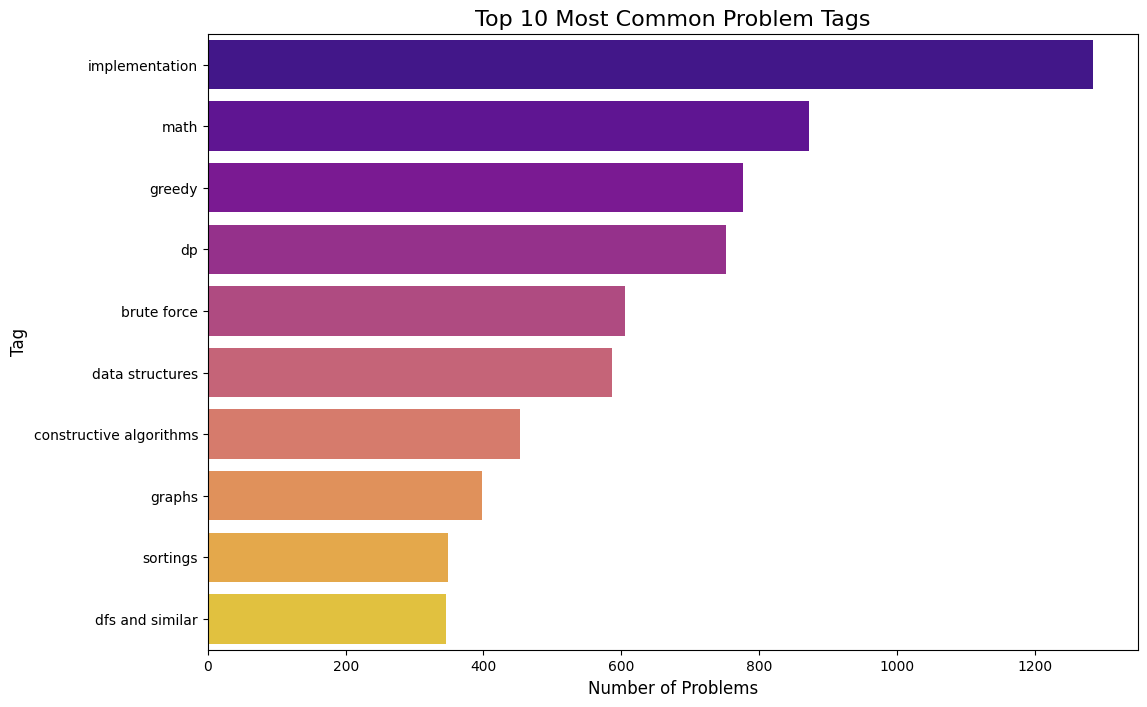

In [26]:
# ====================================================================
# Plot 1: Top 10 Most Common Problem Tags
# ====================================================================

# Explode the tags array to have one tag per row
df_tags = df_featured.withColumn("tag", F.explode(F.col("tags")))

# Count the occurrences of each tag
top_tags = df_tags.groupBy("tag").count().orderBy(F.col("count").desc()).limit(10)
top_tags_pd = top_tags.toPandas()

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="tag", data=top_tags_pd, palette="plasma")
plt.title('Top 10 Most Common Problem Tags', fontsize=16)
plt.xlabel('Number of Problems', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.show()

/tmp/ipython-input-4064078044.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="score_bin", y="description_length", data=plot_data_pd, palette="magma", order=difficulty_order)


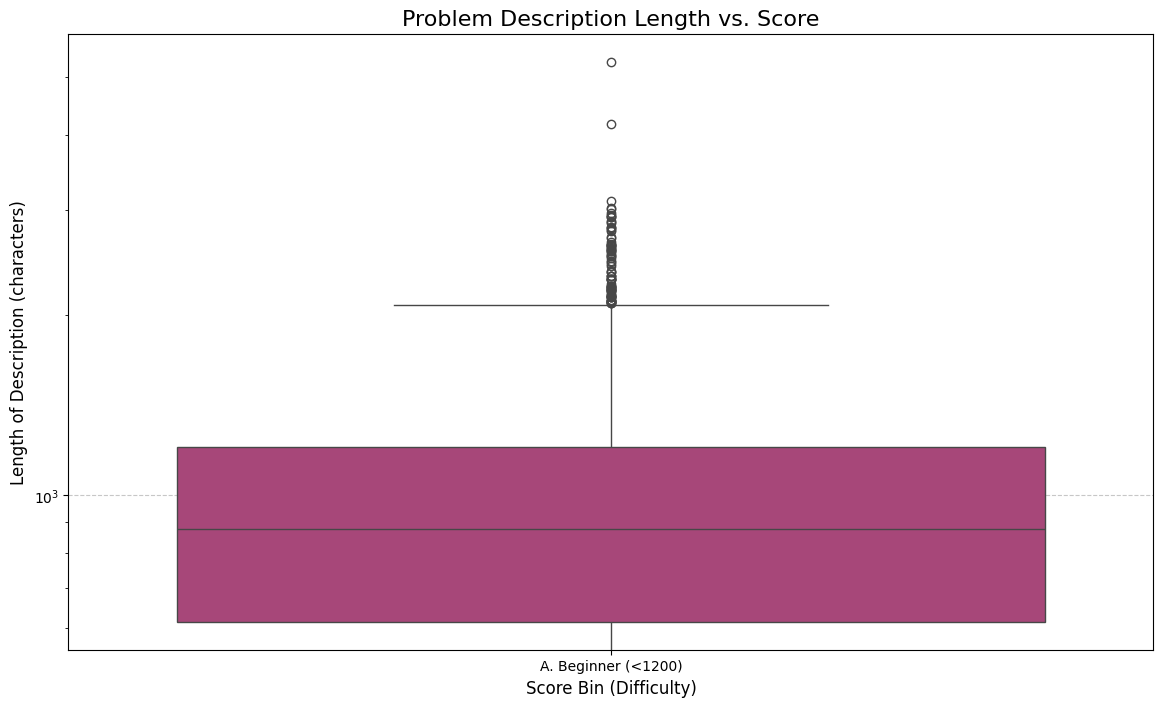

In [27]:
# ====================================================================
# Plot 2: Problem Description Length vs. Score Bin
# ====================================================================

plot_data_pd = df_featured.select("score_bin", "description_length").toPandas()
difficulty_order = sorted(plot_data_pd['score_bin'].unique())

plt.figure(figsize=(14, 8))
sns.boxplot(x="score_bin", y="description_length", data=plot_data_pd, palette="magma", order=difficulty_order)
plt.title('Problem Description Length vs. Score', fontsize=16)
plt.xlabel('Score Bin (Difficulty)', fontsize=12)
plt.ylabel('Length of Description (characters)', fontsize=12)
plt.yscale('log') # Use log scale for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


--> Generating Plot 1: Smoothed Distribution of Scores...


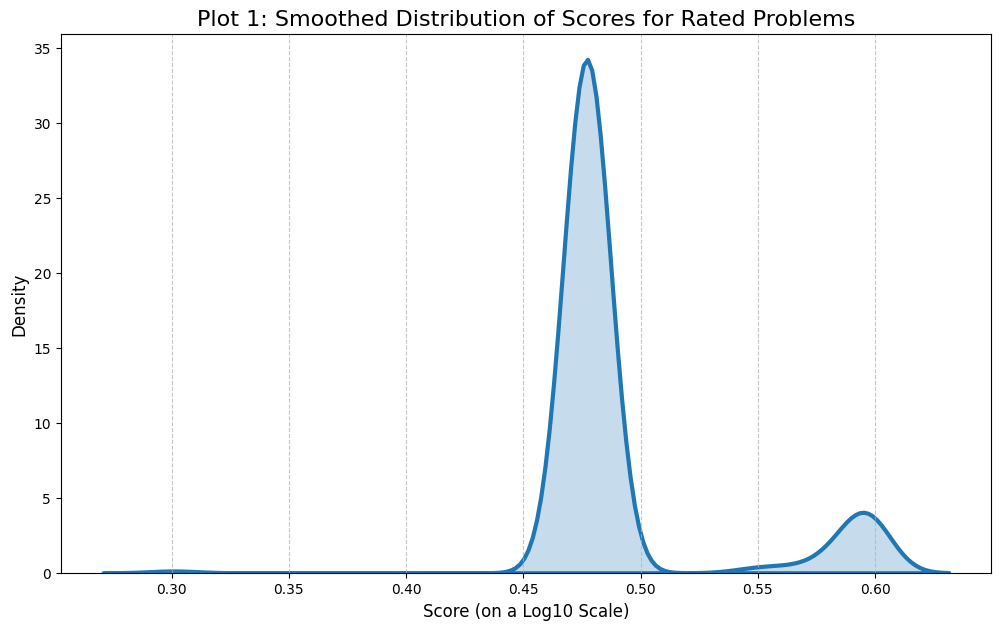


--> Generating Plot 2: Tag Co-occurrence Heatmap...


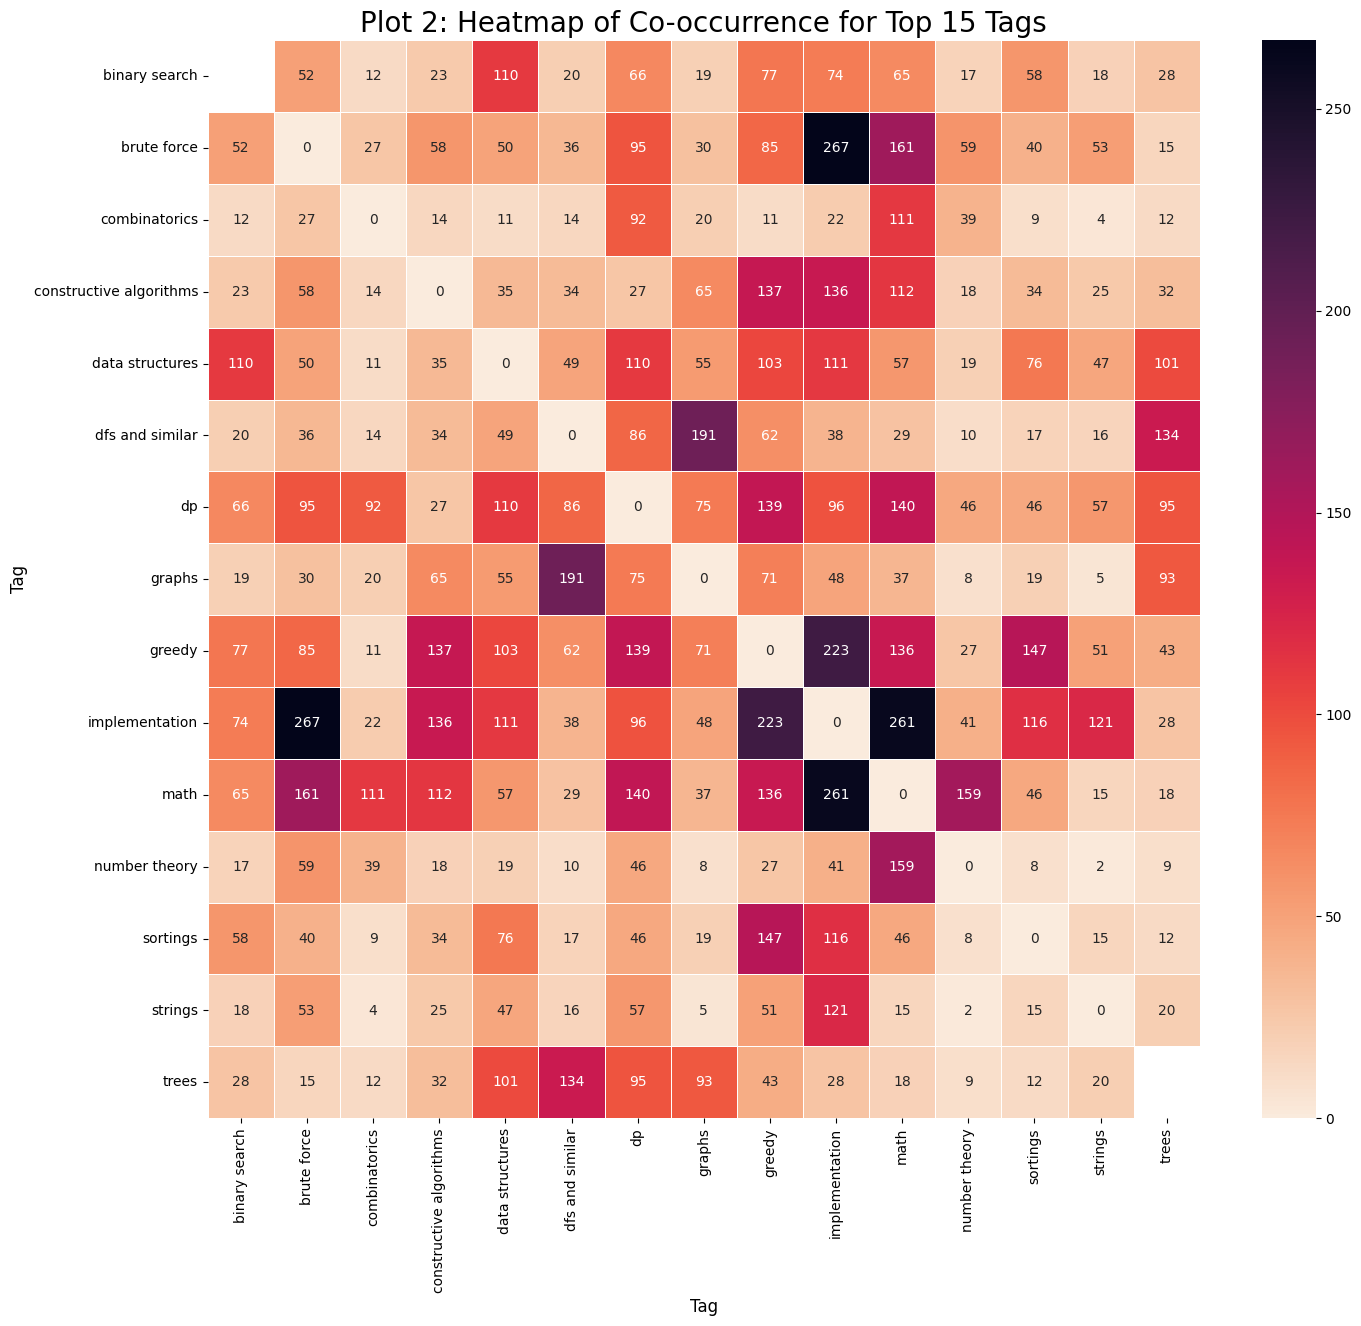


✅ Analysis complete. Spark session has been stopped.


In [29]:
# ====================================================================
# PLOT 1: SMOOTHED DISTRIBUTION OF SCORES
# ====================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

print("\n--> Generating Plot 1: Smoothed Distribution of Scores...")
plot_data_pd_1 = df_featured.select("score").toPandas()
rated_scores_pd = plot_data_pd_1[plot_data_pd_1['score'] > 0].copy()
rated_scores_pd['log_score'] = np.log10(rated_scores_pd['score'])

plt.figure(figsize=(12, 7))
sns.kdeplot(data=rated_scores_pd, x='log_score', fill=True, lw=3)
plt.title('Plot 1: Smoothed Distribution of Scores for Rated Problems', fontsize=16)
plt.xlabel('Score (on a Log10 Scale)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ====================================================================
# PLOT 2: TAG CO-OCCURRENCE HEATMAP
# ====================================================================
print("\n--> Generating Plot 2: Tag Co-occurrence Heatmap...")

# Filter for problems with at least two tags
df_pairs = df_featured.filter(F.size(F.col("tags")) >= 2)
df_tags = df_pairs.select("name", F.explode("tags").alias("tag"))

# Self-join to create all tag pairs for each problem
df_joined = df_tags.alias("df1").join(df_tags.alias("df2"), on="name", how="inner")

# Filter for valid pairs (tag1 < tag2) and count them
tag_pair_counts = df_joined.filter(F.col("df1.tag") < F.col("df2.tag")) \
                           .groupBy(F.col("df1.tag").alias("tag1"), F.col("df2.tag").alias("tag2")) \
                           .count()

# Get the top 15 most frequent tags to keep the heatmap readable
top_15_tags_list = [row['tag'] for row in df_tags.groupBy("tag").count().orderBy(F.col("count").desc()).limit(15).collect()]

# Filter pairs to only include pairs of the top 15 tags
heatmap_data = tag_pair_counts.filter(
    F.col("tag1").isin(top_15_tags_list) & F.col("tag2").isin(top_15_tags_list)
).toPandas()

# Pivot the data into a matrix format suitable for a heatmap
heatmap_pivot = heatmap_data.pivot(index="tag1", columns="tag2", values="count").fillna(0)
heatmap_symmetric = heatmap_pivot.add(heatmap_pivot.T, fill_value=0)

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(heatmap_symmetric, annot=True, fmt=".0f", cmap="rocket_r", linewidths=.5)
plt.title('Plot 2: Heatmap of Co-occurrence for Top 15 Tags', fontsize=20)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.show()

# ====================================================================
# FINAL STEP: STOP THE SPARK SESSION
# ====================================================================
spark.stop()
print("\n✅ Analysis complete. Spark session has been stopped.")